In [1]:
import numpy as np

from typing import Tuple
from utils import graph2adj_matrix
from utils import calculate_alpha
from tqdm import tqdm

In [2]:
def prob2state(prob: np.array) -> np.array:
    """
    Get the state of the node after diffusion according to the probability

    :param prob: probability of being activated
    :return: state array
    """
    return np.where(np.random.uniform(-1, 0, size=prob.shape)+prob >= 0, 1, 0).astype(np.bool_)

class DiffusionEnd(Exception):
    pass

class ICEnv:   
    def __init__(self, graph, k,m):
        self.graph = graph
        self.prob_matrix = graph2adj_matrix(graph)
        self.num_nodes = len(graph.nodes())

        self.state = np.zeros(self.num_nodes).astype(np.bool_)
        self.active = np.zeros(self.num_nodes).astype(np.bool_)

        self.k = k
        self.m=m
        self.pos = nx.spring_layout(self.graph)
        
    def reset(self):
        self.state = np.zeros(self.num_nodes).astype(np.bool_)
        self.active = np.zeros(self.num_nodes).astype(np.bool_)
        return np.concatenate((self.state,self.active))
    
    
    def random_activate_nodes(self, nodes=None):
        if nodes is None:
            activated_nodes = np.random.choice(self.num_nodes, size=self.m, replace=False)
        else:
            activated_nodes = nodes
        for node in activated_nodes:
            self.active[node] = True
        self.state=self.active
        return np.concatenate((self.state,self.active))

    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool]:
      
        try:
            state, active = self.diffusion(action)
            active_num=np.sum(active)
            infected_num=np.sum(state)
            reward = -sum(self.active)/len(self.active)
            done = 0
        
        except DiffusionEnd:
            state = self.state
            active = self.active
            reward = 0
            done = 1

        return np.concatenate((state,active)), reward, done
    
    def diffusion(self, blocker: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        independent cascade process
        """
        if not self.active.any():
            raise DiffusionEnd

        temp_state = np.zeros_like(self.state).astype(np.bool_)

        if isinstance(blocker, np.ndarray):
            blocker = blocker.astype(np.bool_)
        else:
            blocker = np.zeros_like(self.state).astype(np.bool_)

        blocker = (~self.state) & blocker
        for prob in self.prob_matrix[self.active == 1, :]:
            temp_state = prob2state(prob) | temp_state
        temp_state = temp_state & (~blocker)
        self.active = temp_state & (~self.state)
        self.state = temp_state | self.state

        return self.state, self.active

    def draw(self):
        infected = np.arange(len(self.state))[self.state].tolist()
        uninfected = np.arange(len(self.state))[self.state==0].tolist()
        labels = {node: str(node) for node in self.graph.nodes()} # 添加节点编号
        nx.draw_networkx_nodes(self.graph, self.pos, node_size=100, nodelist=infected, node_color="tab:orange")
        nx.draw_networkx_nodes(self.graph, self.pos, node_size=100, nodelist=uninfected, node_color="tab:blue")
        nx.draw_networkx_labels(self.graph, self.pos, labels=labels, font_size=8) # 添加节点编号标签
        nx.draw_networkx_edges(self.graph, self.pos, alpha=0.5, width=1)
        
    def calculate_metrics(self, true_state):
        predicted_state = self.state
        true_positive = np.sum(predicted_state & true_state)
        false_positive = np.sum(predicted_state & (~true_state))
        false_negative = np.sum((~predicted_state) & true_state)

        accuracy = true_positive / len(true_state)
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
        f1_score = 2 * precision * recall / (precision + recall)

        return accuracy, f1_score, recall


In [3]:
# from diffusion import *
import matplotlib.pyplot as plt

import networkx as nx

In [4]:
G = nx.karate_club_graph()
k=1
m=1
env= ICEnv(G,k,m)
n=env.num_nodes

In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#计算动作的模型,也是真正要用的模型
model = torch.nn.Sequential(
    torch.nn.Linear(2*n, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, n),
)

#经验网络,用于评估一个状态的分数
next_model = torch.nn.Sequential(
    torch.nn.Linear(2*n, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, n),
)

print(device)
model.to(device)
next_model.to(device)

cpu


Sequential(
  (0): Linear(in_features=68, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=34, bias=True)
)

In [6]:
import random

def get_action(state, epsilon):
    action = [False] * n  # 创建长度为n的布尔值列表，初始化为False
    # 根据epsilon-greedy策略选择动作
    if random.random() < epsilon:
        # 以epsilon的概率选择随机动作
        indices = random.sample(range(n), k)  # 随机选择k个索引
        for i in indices:
            action[i] = True
    else:
        # 以1-epsilon的概率选择模型预测的最优动作
        with torch.no_grad():
            state = torch.FloatTensor(state).reshape(1, 2*n)
            q_values = model(state)
            _, topk_indices = q_values.topk(k)  # 获取前k个最大值的索引
            if k==1:
                action[topk_indices] = True 
            else:
                topk_indices = topk_indices.squeeze().tolist()  # 将张量转换为列表
                for i in topk_indices:
                    action[i] = True              
    return action

In [7]:
#样本池
datas = []
epsilon = 1.0  # 初始epsilon值
epsilon_decay = 0.99  # epsilon衰减率

#向样本池中添加N条数据,删除M条最古老的数据
def update_data(epsilon,epsilon_decay):
    old_count = len(datas)

    #玩到新增了N个数据为止
    while len(datas) - old_count < 200:
        #初始化游戏
        env.reset()
        state=env.random_activate_nodes()
        #env.draw()

        #玩到游戏结束为止
        over = False
        while not over:
            #根据当前状态得到一个动作
            state_all = state[:n]
            action = get_action(state,epsilon)
            reward_new=0
            if any([x and y for x, y in zip(state_all, action)]):
                reward_new +=-1
            next_state, reward, over= env.step(action)
            reward=reward+reward_new
            #记录数据样本
            datas.append((state, action, reward, next_state, over))

            #更新游戏状态,开始下一个动作
            state = next_state

    update_count = len(datas) - old_count
    drop_count = max(len(datas) - 10000, 0)

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 10000:
        datas.pop(0)
        
    # 衰减epsilon值
    epsilon *= epsilon_decay
    
    return update_count, drop_count

update_data(epsilon,epsilon_decay), len(datas)

((203, 0), 203)

In [8]:
#获取一批数据样本
def get_sample():
    #从样本池中采样
    samples = random.sample(datas, 64)

    #[b, 4]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 2*n)
    #[b, 1]
    action = torch.LongTensor([i[1] for i in samples]).reshape(-1, n)
    #[b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
    #[b, 4]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 2*n)
    #[b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over

state, action, reward, next_state, over = get_sample()
print("state",state)
print("action",action) 
print("reward",reward)
print("next_state",next_state)
print("over",over)

state tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
action tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 1, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
reward tensor([[-0.0294],
        [ 0.0000],
        [ 0.0000],
        [-1.0000],
        [-0.0294],
        [-0.0294],
        [-0.0294],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-1.0000],
        [-0.0294],
        [-0.1176],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-1.0000],
        [-0.0294],
        [ 0.0000],
        [-0.0294],
        [ 0.0000],
        [ 0.0000],
        [ 0.00

C:\Users\DQ\AppData\Local\Temp\ipykernel_6872\485245448.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 2*n)


In [9]:
def get_value(state, action):
    #使用状态计算出动作的logits
    #[b, 4] -> [b, 2]
    value = model(state)
    if k==1:
        action_indices = torch.stack([torch.nonzero(row).squeeze() for row in action])
        action_indices = action_indices.unsqueeze(1)
    else:
        action_indices = torch.stack([torch.nonzero(row).squeeze() for row in action])
    #根据实际使用的action取出每一个值
    #这个值就是模型评估的在该状态下,执行动作的分数
    #在执行动作前,显然并不知道会得到的反馈和next_state
    #所以这里不能也不需要考虑next_state和reward
    #[b, 2] -> [b, 1]
    value = value.gather(dim=1, index=action_indices)

    return value

# value = get_value(state, action)


In [10]:
def get_target(reward, next_state, over):
    #上面已经把模型认为的状态下执行动作的分数给评估出来了
    #下面使用next_state和reward计算真实的分数
    #针对一个状态,它到底应该多少分,可以使用以往模型积累的经验评估
    #这也是没办法的办法,因为显然没有精确解,这里使用延迟更新的next_model评估

    #使用next_state计算下一个状态的分数
    #[b, 4] -> [b, 2]
    with torch.no_grad():
        target = next_model(next_state)

    #取所有动作中分数最大的
    #[b, 2] -> [b, 1]
    target = target.topk(k, dim=1)[0]
    target = target.reshape(-1, target.shape[1])
   
    #下一个状态的分数乘以一个系数,相当于权重
    target *= 0.98

    #如果next_state已经游戏结束,则next_state的分数是0
    #因为如果下一步已经游戏结束,显然不需要再继续玩下去,也就不需要考虑next_state了.
    #[b, 1] * [b, 1] -> [b, 1]
    target *= (1 - over)

    #加上reward就是最终的分数
    #[b, 1] + [b, 1] -> [b, 1]
    target += reward

    return target

# get_target(reward, next_state,over)

In [11]:
def test(play):
    epsilon=0
    #初始化游戏
    env.reset()
    state=env.random_activate_nodes()
    if play:
        env.draw()
    #env.draw()
    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state,epsilon)
       

        #执行动作,得到反馈
        state, reward, over= env.step(action)
        reward_sum += reward
        state_all = state[:n]
        activate_node=state[n:2*n]
#         env.draw()
    
    # 另存0到n-1的元素为state_all列表
    state_all_final = state[:n]
    activate_node_final=state[n:2*n]

    # 统计感染率
    infection_rate = sum(state_all_final) / len(state_all_final)

    return reward_sum, state_all_final, activate_node_final, infection_rate


In [13]:
from torch.nn import SmoothL1Loss
from torch.utils.tensorboard import SummaryWriter

epsilon = 1.0  # 初始epsilon值
epsilon_decay = 0.99  # epsilon衰减率
def train():
    model.train()
    model.to(device)
    next_model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    #loss_fn = torch.nn.SmoothL1Loss()
    loss_fn = SmoothL1Loss()
    writer = SummaryWriter()
    #训练N次
    bar = tqdm(range(500))
    for epoch in bar:
        #更新N条数据
        update_count, drop_count = update_data(epsilon,epsilon_decay)

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = get_sample()
            state = state.to(device)
            action = action.to(device)
            reward = reward.to(device)
            next_state = next_state.to(device)
            over = over.to(device)
            
            
            #计算一批样本的value和target
            value = get_value(state, action)
            target = get_target(reward, next_state, over)

            #更新参数
            loss = loss_fn(value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #把model的参数复制给next_model
            if (i + 1) % 10 == 0:
                next_model.load_state_dict(model.state_dict())

        if epoch % 50 == 0:
            test_result = sum([test(play=False)[0] for _ in range(20)]) / 20
#             print(epoch, len(datas), update_count, drop_count, test_result,loss)
            
            
            # 写入reward_sum和loss的值到SummaryWriter
            writer.add_scalar('Reward Sum', test_result, epoch)
            writer.add_scalar('Loss', loss.item(), epoch)
            
            test_result, state_all_final, activate_node_final, infection_rate = test(play=False)
            accuracy, f1_score, recall = env.calculate_metrics(state_all_final)

            # 写入指标值到SummaryWriter
            writer.add_scalar('Accuracy', accuracy, epoch)
            writer.add_scalar('F1 Score', f1_score, epoch)
            writer.add_scalar('Recall', recall, epoch)
    # 关闭SummaryWriter
    writer.close()

train()

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 12.26it/s]


In [14]:
def test(play):
    epsilon = 0
    # 初始化游戏
    env.reset()
    state = env.random_activate_nodes()

    # 记录反馈值的和,这个值越大越好
    reward_sum = 0
    time=-1

    # 玩到游戏结束为止
    over = False
    while not over:
        time+=1
        # 根据当前状态得到一个动作
        action = get_action(state, epsilon)

        # 执行动作,得到反馈
        state, reward, over = env.step(action)
        reward_sum += reward

    # 另存0到n-1的元素为state_all列表
    state_all_final = state[:n]

    # 统计感染率
    infection_rate = sum(state_all_final) / len(state_all_final)

    return reward_sum, state_all_final, infection_rate,time


In [15]:
def test_another(play):
    epsilon = 0
    # 初始化游戏
    env.reset()
    state = env.random_activate_nodes()

    # 记录反馈值的和,这个值越大越好
    reward_sum = 0
    time=-1

    # 玩到游戏结束为止
    over = False
    while not over:
        time+=1
        # 根据当前状态得到一个动作
        action = get_action(state, epsilon)

        # 执行动作,得到反馈
        state, reward, over = env.step(action)
        reward_sum += reward

    # 另存0到n-1的元素为state_all列表
    state_all_final = state[:n]

    # 统计感染率
    infection_rate = sum(state_all_final) / len(state_all_final)

    return reward_sum, state_all_final, infection_rate,time

def test_multiple_times(number):
    total_reward_sum = 0
    total_infection_rate = 0
    time_sum=0
    
    for _ in range(number):
        reward_sum, _, infection_rate,time = test_another(play=False)
        total_reward_sum += reward_sum
        total_infection_rate += infection_rate
        time_sum+=time

    average_reward_sum = total_reward_sum / number
    average_infection_rate = total_infection_rate / number
    average_time_sum=time_sum/number
    return average_reward_sum, average_infection_rate, average_time_sum


In [16]:
def test_three():
    epsilon = 0
    # 初始化游戏

    total_reward_sum = 0
    total_infection_rate = 0
    time_sum=0

    for node in G.nodes():
        env.reset()
        state = env.random_activate_nodes([node])

        # 记录反馈值的和,这个值越大越好
        reward_sum = 0

        # 玩到游戏结束为止
        over = False
        time=-1
        while not over:
            time+=1
            # 根据当前状态得到一个动作
            action = get_action(state, epsilon)

            # 执行动作,得到反馈
            state, reward, over = env.step(action)
            reward_sum += reward

        # 另存0到n-1的元素为state_all列表
        state_all_final = state[:n]

        # 统计感染率
        infection_rate = sum(state_all_final) / len(state_all_final)
        total_reward_sum += reward_sum
        total_infection_rate += infection_rate
        time_sum+=time

    return total_reward_sum / len(G.nodes()), total_infection_rate / len(G.nodes()),time_sum/len(G.nodes())

average_reward_sum, average_infection_rate,time_sum = test_three()

print("Test Result:", average_reward_sum)
print("Infection Rate:", average_infection_rate)
print("time_sum:", time_sum)

Test Result: -0.020761245674740487
Infection Rate: 0.05017301038062281
time_sum: 1.411764705882353


In [17]:
test_result, state_all_final, infection_rate,time = test(play=True)
accuracy, f1_score, recall = env.calculate_metrics(state_all_final)


print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Recall:", recall)
print("Test Result:", test_result)
print("Infection Rate:", infection_rate)
print("time:", time)

Accuracy: 0.029411764705882353
F1 Score: 1.0
Recall: 1.0
Test Result: 0.0
Infection Rate: 0.029411764705882353
time: 1


In [18]:
average_reward_sum, average_infection_rate, average_time_sum =test_multiple_times(170)

print("Test Result:", average_reward_sum)
print("Infection Rate:", average_infection_rate)
print("time_sum:", time_sum)

Test Result: -0.034775086505190296
Infection Rate: 0.06418685121107257
time_sum: 1.411764705882353


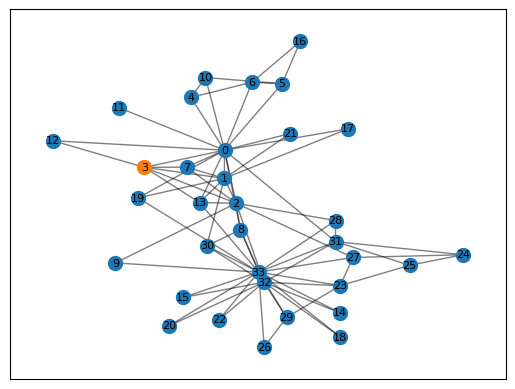

In [19]:
env.draw()